## Time to get your hands dirty. Galaxies vs quasars with neural networks.

Let's go back to our galaxy vs quasar data we've used in a previous exercise. 

1. Read in SDSS galaxy color data from `solutions/galaxyquasar.csv`. Create arrays for the $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create an array with the class labels where galaxy=$0$ and quasar=$1$. 

2. Now we're going to fit a neural network classifier. First, scale your data appropriately and do a 30% train/test split.

3. Now train the classifier. Use one the package among those we've seen. These include Tensorflow via keras, pytorch, and the MPL classifier implemented in scikit-learn. This is an opportunity to pick the one you're most interested in learning. 

3. Start from a network architecture with a single hidden layer with 5 neurons, using the `adam` solver, the `relu` activation function, and a learninig rate of `0.001`. Plot the resulting ROC curve. 

4. Now let's optimize the hyperparameters of your network. Explore different hyperparameters and see what fits the data best.  Do your best now to optimize the network architecture. Be creative!

5. Is your best result comparable with the simpler classifiers we've seen before? Do we need deep learning here? If yes, which features are captured best?

In [33]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import random
import pandas as pd
import corner
from sklearn.model_selection import train_test_split, KFold
import deepdish
import os
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import roc_curve, auc
import keras_tuner
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2
from tensorflow.keras.metrics import Precision, Recall
import json

plt.rc('text', usetex=True)  
plt.rc('font', family='serif')

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
df = pd.read_csv('../../solutions/galaxyquasar.csv')

In [3]:
df

,u,g,r,i,z,class,z1,zerr
0,18.97213,18.53676,18.58280,18.34936,18.29215,QSO,0.522819,0.000155
1,19.24592,17.47646,16.47817,16.04472,15.68851,GALAXY,0.122846,0.000028
2,19.43536,17.70268,16.91565,16.58327,16.39128,GALAXY,0.000000,0.000000
3,19.31626,18.18312,17.39591,16.94549,16.65395,GALAXY,0.147435,0.000009
4,19.28828,19.11188,18.88937,18.80013,18.49183,QSO,2.011455,0.000631
...,...,...,...,...,...,...,...,...
49995,19.37295,18.12382,17.39886,16.98503,16.70585,GALAXY,0.113016,0.000011
49996,18.52021,16.88262,16.03280,15.56884,15.22454,GALAXY,0.085063,0.000014
49997,18.62718,17.30876,16.87371,16.62399,16.42296,GALAXY,0.054429,0.000008
49998,19.55140,18.27711,17.62101,17.21947,17.03347,GALAXY,0.112571,0.000009


In [4]:
ug = np.array(df['u']-df['g'])
gr = np.array(df['g']-df['r'])
ri = np.array(df['r']-df['i'])
iz = np.array(df['i']-df['z'])

labels = np.where(df['class'] == 'QSO', 1, 0)

Rescale my data between -1 and 1

In [5]:
def rescaling(x, min_val, max_val):
    return 2. * ((x - min_val) / (max_val - min_val)) - 1.


In [6]:
ug_scaled = rescaling(ug, np.min(ug), np.max(ug))
gr_scaled = rescaling(gr, np.min(gr), np.max(gr))
ri_scaled = rescaling(ri, np.min(ri), np.max(ri))
iz_scaled = rescaling(iz, np.min(iz), np.max(iz))

X = np.column_stack((ug_scaled, gr_scaled, ri_scaled, iz_scaled))
X_train, X_test, lab_train, lab_test = train_test_split(X, labels, test_size=0.3, random_state=7)

In [38]:
def train_basic_network(train_gal, train_lab, test_gal, test_lab, filename='trained.h5'):
    history = None 
    if not os.path.isfile(filename):

        train_in  = train_gal
        train_out = train_lab
        test_in  = test_gal
        test_out = test_lab

        #init
        my_init = keras.initializers.glorot_uniform(seed=1)
        
        #architecture
        model = keras.Sequential([
            #input
            tf.keras.layers.InputLayer(input_shape=np.shape(train_in[0])),
            
            #hidden
            keras.layers.Dense(5, activation='relu', kernel_initializer=my_init),
            
            #output
            keras.layers.Dense(1, activation='sigmoid', kernel_initializer=my_init)
        ])

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=1e-3),
            loss='binary_crossentropy',
            metrics=['accuracy', Precision(), Recall()]
        )

        history = model.fit(
            train_in, 
            train_out,   
            validation_data=(test_in, test_out),
            batch_size=20,       
            epochs=150,         
            callbacks=[
                tf.keras.callbacks.ModelCheckpoint(
                    filepath=filename,
                    save_weights_only=False,
                    monitor='val_accuracy',
                    mode='max',
                    save_best_only=True),
                tf.keras.callbacks.TensorBoard(log_dir="logs" + filename.split('.h5')[0], histogram_freq=1)
            ],
            shuffle=True,
            verbose=0            #shorter output
        )

    model = loadnetwork(filename)
    return model, history

def f1_score(precision, recall):
    return 2 * ((precision * recall) / (precision + recall))

def loadnetwork(filename,verbose=False):
    '''
    Load a trained neural network ()
    '''

    model = tf.keras.models.load_model(filename)
    if verbose:
        model.summary()

    return model

def testnetwork(model,test_gal,test_lab):
   '''
   Test network on a series of galaxies
   '''
   test_in  = test_gal
   test_out = test_lab
   model.evaluate(test_in,  test_out, verbose=2)


def predictnetwork(model, test_gal):
    '''
    Use a network to predict the detectability of a set of galaxies.
    '''
    #class (0 or 1)
    predictions = np.squeeze((model.predict(test_gal) > 0.5).astype("int32"))
    return predictions


def plot_roc_curve(model, test_gal, test_lab):
    '''
    Plot the ROC curve for the given model and test data.
    Calls predictnetwork to get predicted probabilities.
    '''
    pred_probabilities = predictnetwork(model, test_gal)
    
    fpr, tpr, thresholds = roc_curve(test_lab, pred_probabilities)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='pink', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 0.5])
    plt.ylim([0.6, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()

def plots_history(history):
    '''
    Plot the accuracy and the loss as a function of the epochs.
    '''
    plt.plot(history.history['accuracy'], color='purple')
    plt.plot(history.history['val_accuracy'], color='violet')
    plt.title('Accuracy over epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    plt.show()
    
    plt.plot(history.history['loss'],color='purple')
    plt.plot(history.history['val_loss'], color='violet')
    plt.title('Loss over epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

In [44]:
model, history = train_basic_network(X_train, lab_train, X_test, lab_test, filename='trained.h5')

In [19]:
model = loadnetwork('trained.h5')

In [45]:
testnetwork(model, X_test, lab_test)

469/469 - 2s - loss: 0.0671 - accuracy: 0.9833 - precision: 0.9507 - recall: 0.9322 - 2s/epoch - 4ms/step


469/469 [==============================] - 2s 3ms/step


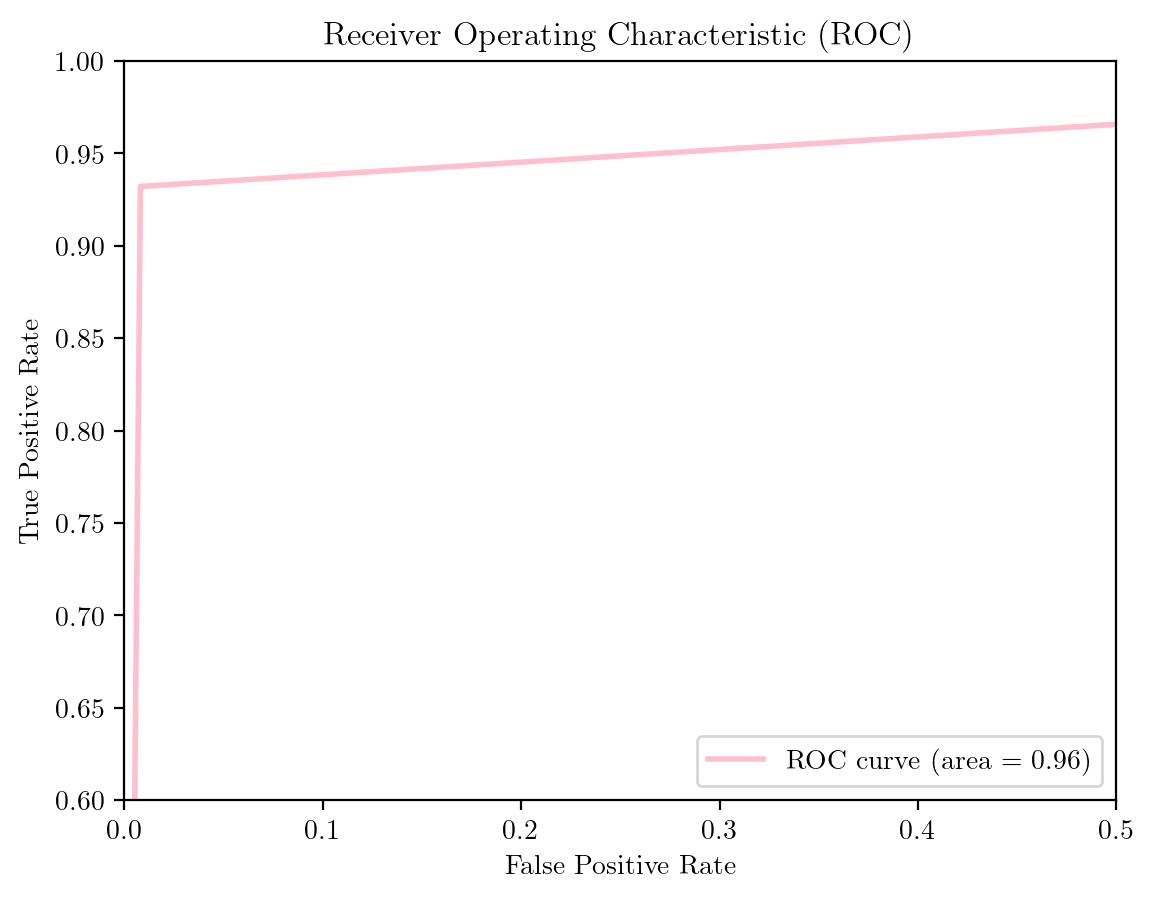

In [46]:
plot_roc_curve(model, X_test, lab_test)

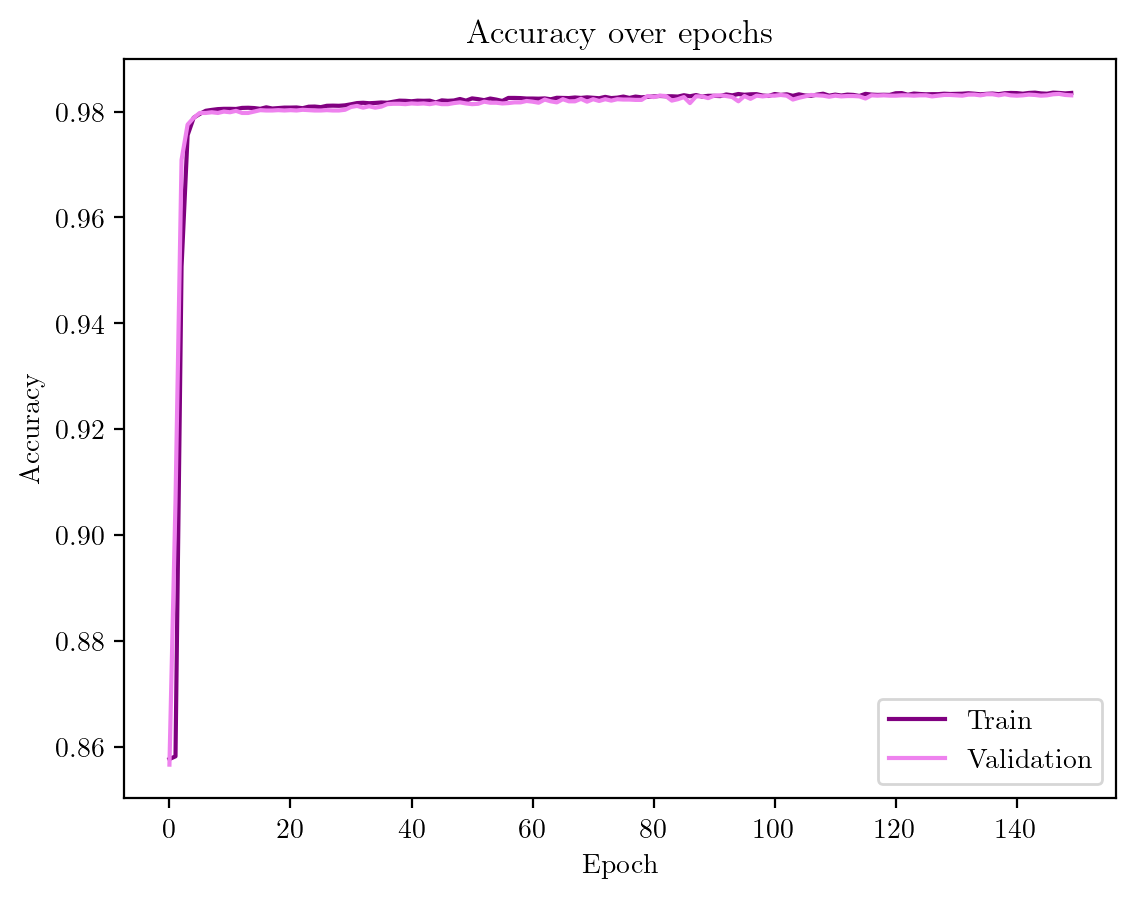

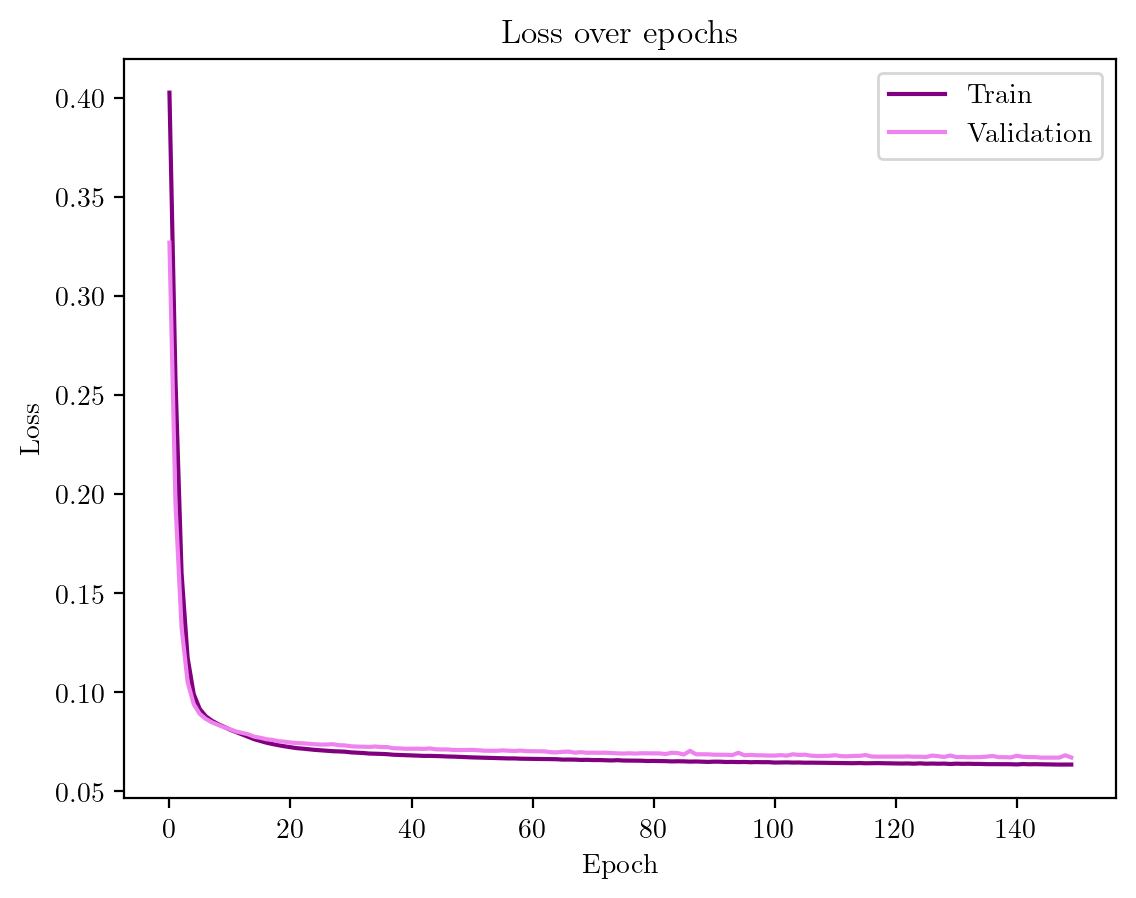

In [76]:
plots_history(history)

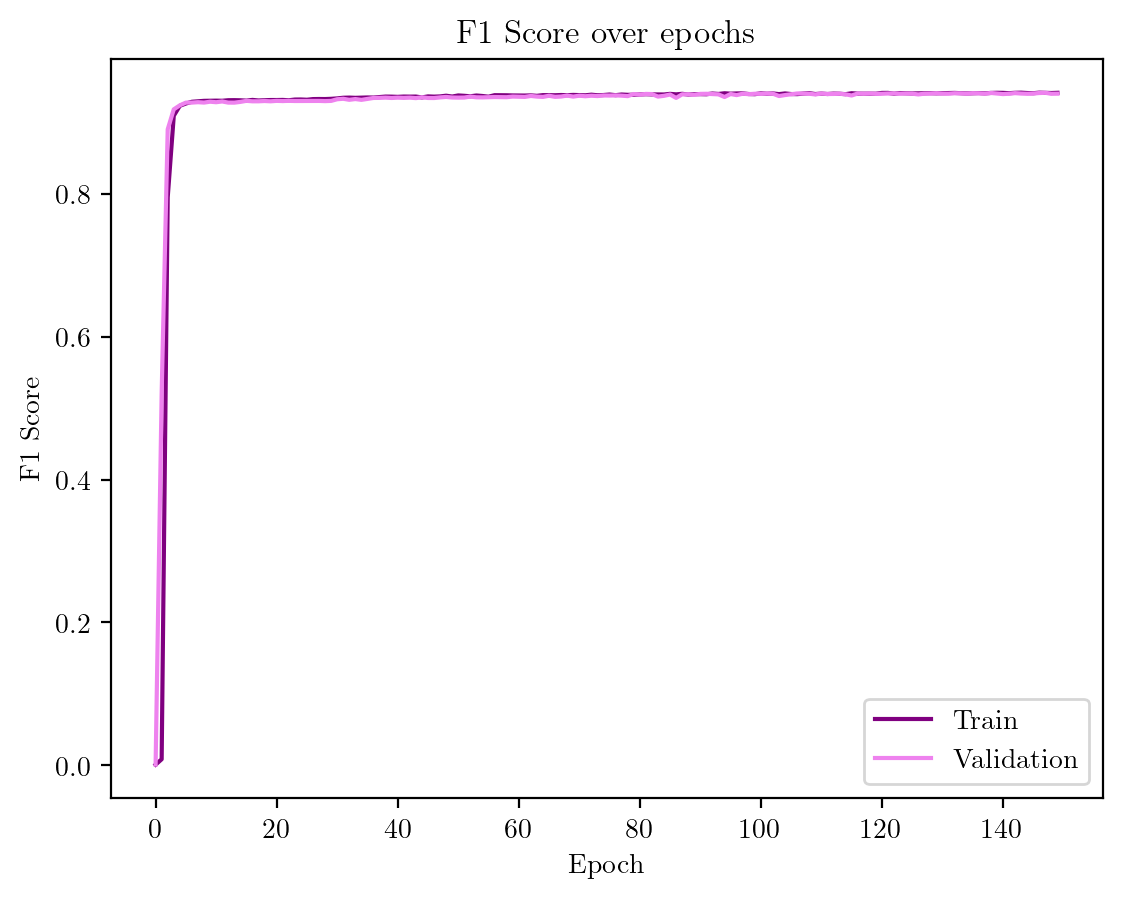

F1_score: 0.9413420950803966


In [73]:
precision = history.history['precision']
recall = history.history['recall']
val_precision = history.history['val_precision']
val_recall = history.history['val_recall']

#compute f1
f1_scores = [f1_score(p, r) for p, r in zip(precision, recall)]
val_f1_scores = [f1_score(p, r) for p, r in zip(val_precision, val_recall)]

plt.plot(f1_scores, color='purple')
plt.plot(val_f1_scores, color='violet')
plt.title('F1 Score over epochs')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

print('F1_score:', np.max(val_f1_scores))

In this case the performance is worse than the KNeighbors Classifiers used in the ex. of lecture 19, anyway it's very close and I haven't tuned anything yet

## Optimization of the hyperparameters

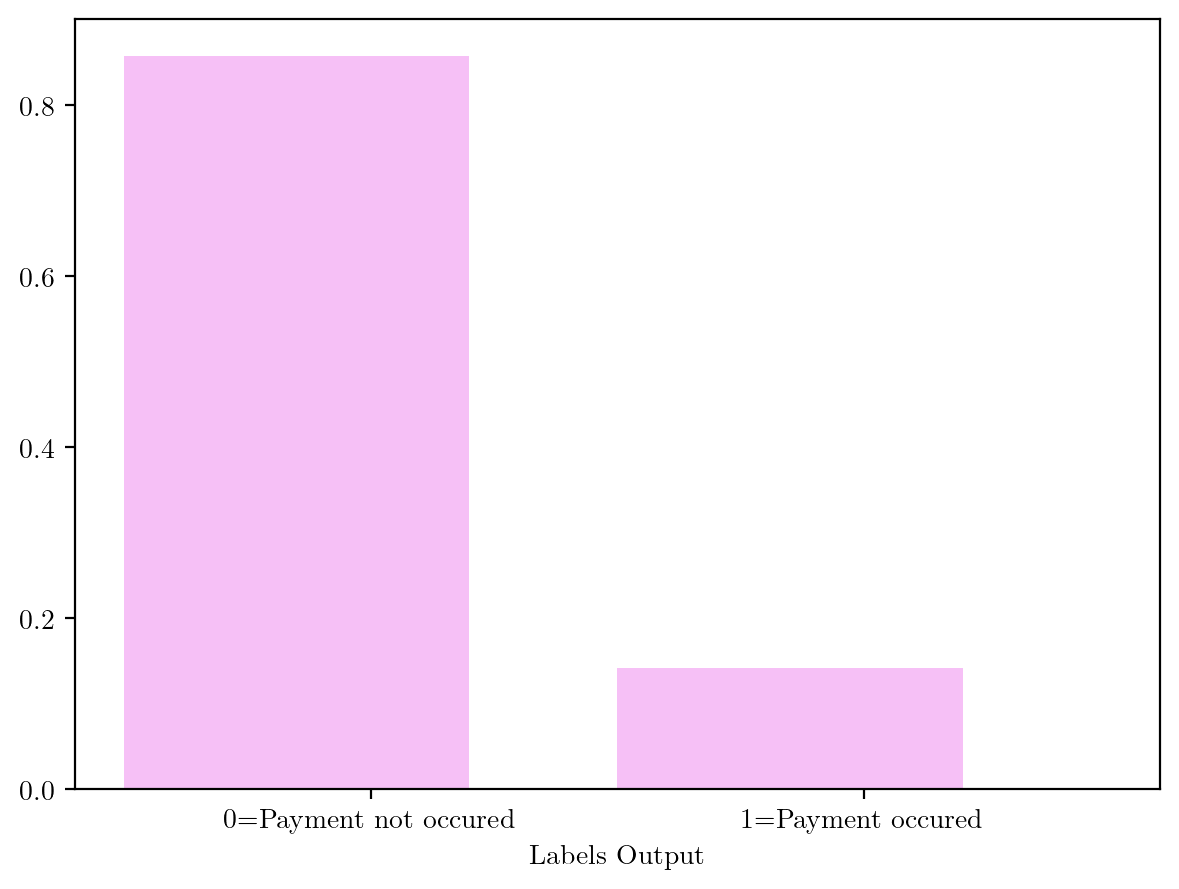

In [14]:
plt.figure(figsize=(7, 5))
bins = [-0.5, 0.5, 1.5]
plt.hist(lab_train, bins, histtype='bar',  density=True, align='mid', width=0.7, color='violet', alpha=0.5)
plt.xticks([0, 1], ['0=Payment not occured','1=Payment occured '])
plt.xlabel('Labels Output')
plt.show()


With the above histogram I wanted to check if the targets were balanced or not.
Since they're not this should be taken into consideration in the costruction of the achitecture and in order to improve the performance of my NN. I will add a weight in the classes.

Then I am adding a second layer to see if the depth of the network can improve my performance. With the same scope I have decided to add a changing in the learning rate when the accuracy got stucked for more than 5 epochs, but because I want to avoid overfitting I am putting an L2 regularization.

I also want to compute F1 score that it's more informative than accuracy in the case of very unbalanced classes like here. 

In [50]:
def trainnetwork(train_gal, train_lab, test_gal, test_lab, filename='trained.h5'):

    if not os.path.isfile(filename):

        class_weight_dict = {
        0: 1.0,
        1: 1.5  }
        
        train_in  = train_gal
        train_out = train_lab
        test_in  = test_gal
        test_out = test_lab

        #init
        my_init = keras.initializers.glorot_uniform(seed=1)
        
        #architecture
        model = keras.Sequential([
            #input
            tf.keras.layers.InputLayer(input_shape=np.shape(train_in[0])),
            
            #hidden
            keras.layers.Dense(5, activation='relu', kernel_initializer=my_init),

            #hidden
            keras.layers.Dense(7, activation='tanh', kernel_initializer=my_init, kernel_regularizer=l2(0.0001)),
            
            #output
            keras.layers.Dense(1, activation='sigmoid', kernel_initializer=my_init)
        ])
            
        #Add learning rate reduction when plateau in accuracy
        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,       #reduce LR by half
            patience=8,       #wait 8 epochs before reducing
            min_lr=0.00005,
            verbose=1
        )

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=1e-3),
            loss='binary_crossentropy',
            metrics=['accuracy', Precision(), Recall()]
        )

        history = model.fit(
            train_in, 
            train_out,   
            validation_data=(test_in, test_out),
            batch_size=20,       
            epochs=150,         
            callbacks=[
                reduce_lr,
                tf.keras.callbacks.ModelCheckpoint(
                    filepath=filename,
                    save_weights_only=False,
                    monitor='val_accuracy',
                    mode='max',
                    save_best_only=True),
                tf.keras.callbacks.TensorBoard(log_dir="logs" + filename.split('.h5')[0], histogram_freq=1)
            ],
            shuffle=True,
            verbose=0            #shorter output
        )

    model = loadnetwork(filename)
    return model, history

In [51]:
model_update, history_update = trainnetwork(X_train, lab_train, X_test, lab_test, filename='trained.h5')


Epoch 105: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 115: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 132: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 140: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 150: ReduceLROnPlateau reducing learning rate to 5e-05.


In [19]:
model = loadnetwork('trained.h5')

In [52]:
testnetwork(model_update, X_test, lab_test)

469/469 - 3s - loss: 0.0638 - accuracy: 0.9844 - precision_1: 0.9554 - recall_1: 0.9349 - 3s/epoch - 6ms/step


469/469 [==============================] - 1s 3ms/step


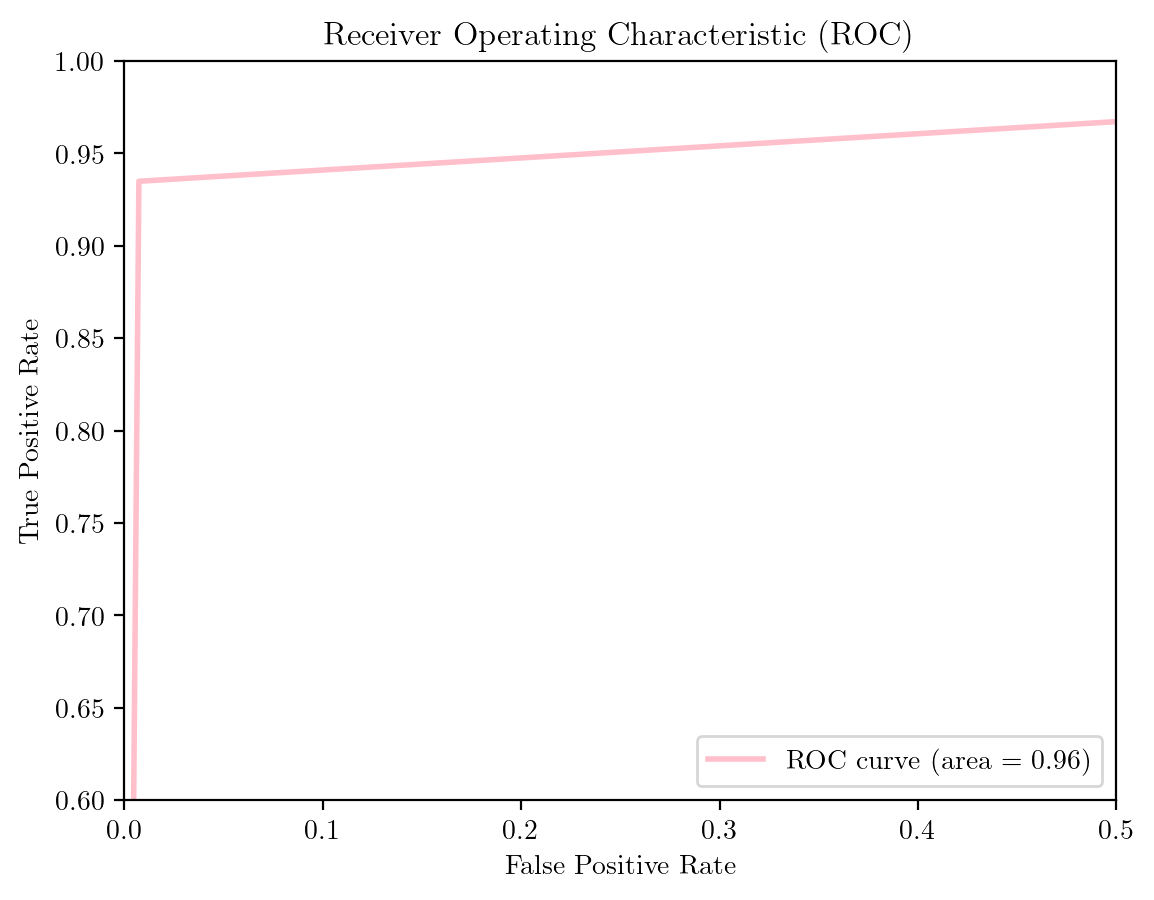

In [77]:
plot_roc_curve(model_update, X_test, lab_test)

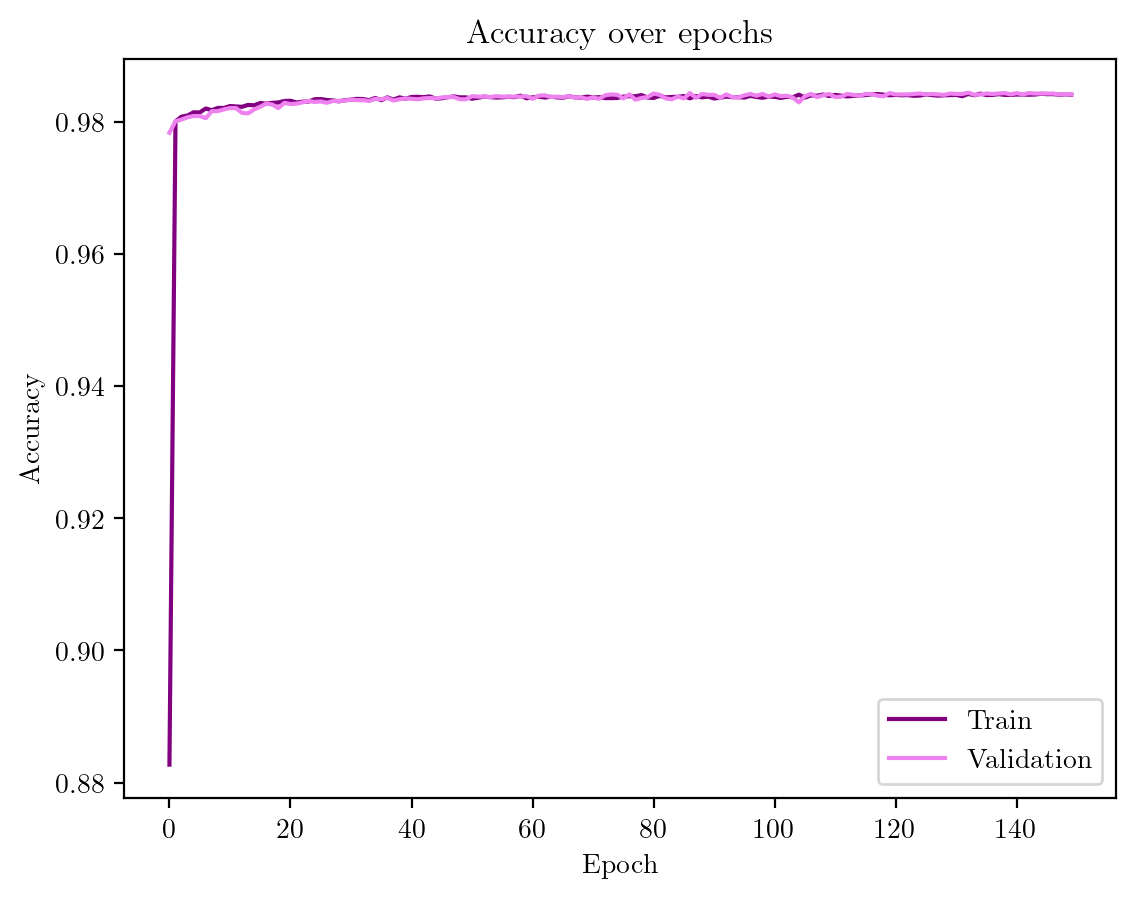

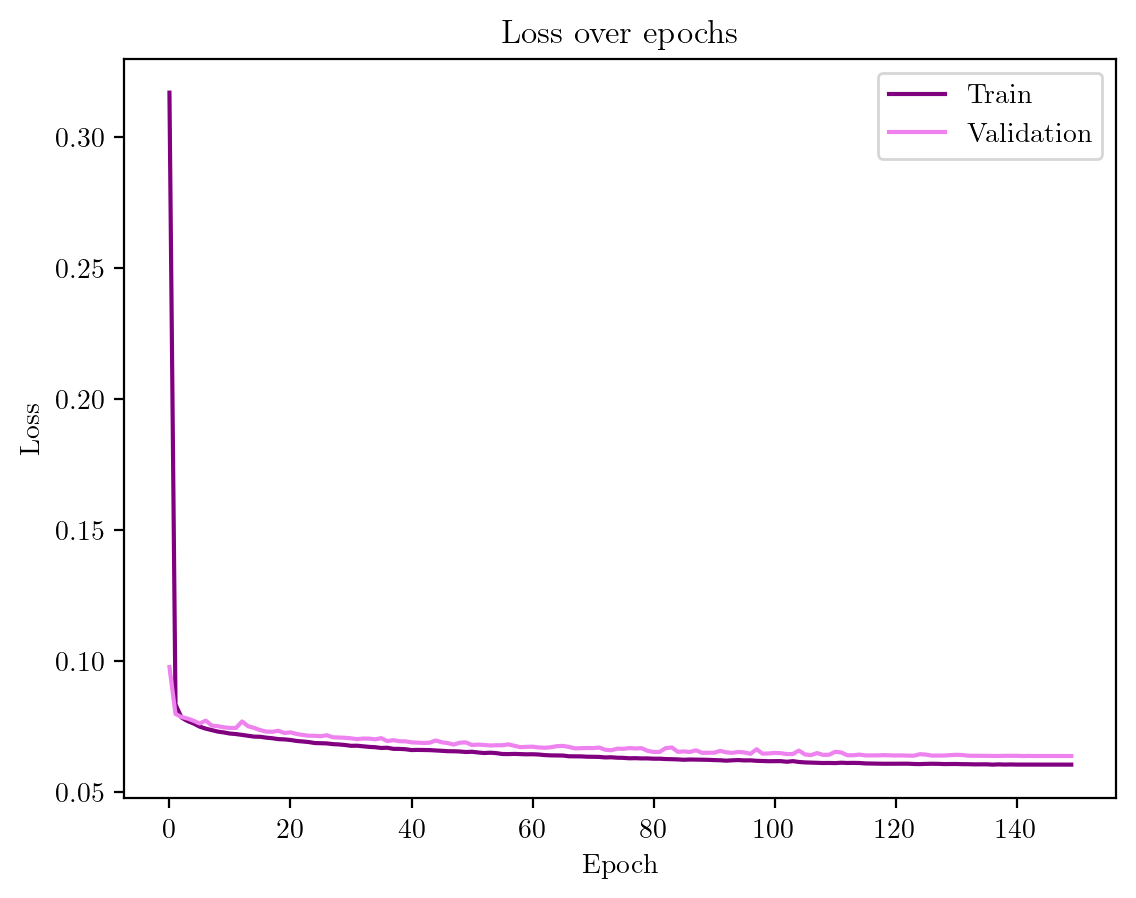

In [78]:
plots_history(history_update)

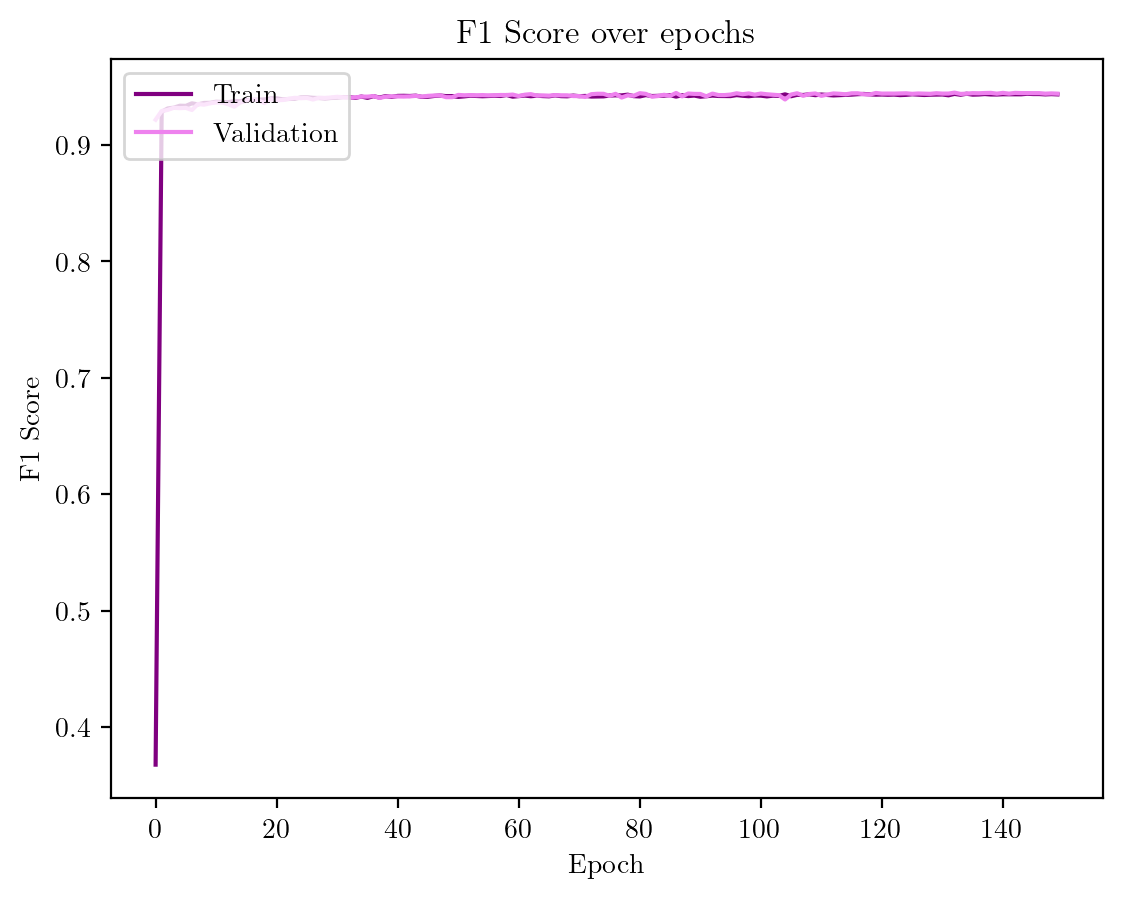

F1_score: 0.9450445972114585


In [79]:
precision = history_update.history['precision_1']
recall = history_update.history['recall_1']
val_precision = history_update.history['val_precision_1']
val_recall = history_update.history['val_recall_1']

#compute f1
f1_scores = [f1_score(p, r) for p, r in zip(precision, recall)]
val_f1_scores = [f1_score(p, r) for p, r in zip(val_precision, val_recall)]

plt.plot(f1_scores, color='purple')
plt.plot(val_f1_scores, color='violet')
plt.title('F1 Score over epochs')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
print('F1_score:', np.max(val_f1_scores))

The performance is better than the previous architecture, but still the accuracy is comparable to the one achieved by KNN with 10 neighbors and all the features.
I don't think that it's necessary a NN for this kind of job.

### K fold cross validation with 120 combinations

In [ ]:
tf.get_logger().setLevel(logging.ERROR)

# Definizione del modello con tuner
def build_model(hp):
    model = tf.keras.Sequential()
    
    # Numero di layer nascosti
    num_layers = hp.Int('num_layers', min_value=1, max_value=3, step=1)
    
    for i in range(num_layers):
        units = hp.Choice(f'units_{i}', [5, 7, 10, 15, 20])
        activation = hp.Choice(f'activation_{i}', ['relu', 'tanh'])
        model.add(tf.keras.layers.Dense(units, activation=activation))
    
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    # Definisce la scelta del moltiplicatore per i pesi di classe
    class_weight_multiplier = hp.Choice('class_weight_multiplier', [1.0, 1.5])

    # Compilazione del modello
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='binary_crossentropy'
    )
    
    # Aggiunge i pesi di classe come attributo nel modello
    model.class_weight = {0: 1.0, 1: class_weight_multiplier}
    
    return model

# Configurazione del tuner
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=120,
    directory='keras_tuner_dir',
    project_name='kfold_cross_val_search'
)

# Funzione per il K-Fold CV con tuner
def cross_val_with_tuner(X, y, k=5, epochs=10):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    trial_results = []
    
    # Lancia la ricerca dei migliori iperparametri
    tuner.search_space_summary()
    tuner.search(X, y, epochs=epochs, validation_split=0.2)  # usa temporaneamente validation_split

    # Recupera tutti i trials completati
    for trial in tuner.oracle.get_best_trials(num_trials=220):
        fold_losses = []

        hp = trial.hyperparameters
        model = tuner.hypermodel.build(hp)
        
        for fold, (train_idx, val_idx) in enumerate(kf.split(X), start=1):
            print(f"\n Fold {fold} di {k}")
            X_train_fold, X_val_fold = X[train_idx], X[val_idx]
            y_train_fold, y_val_fold = y[train_idx], y[val_idx]
            
            # Callbacks
            reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00005, verbose=0)
            early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
            
            # Recupera i pesi di classe dal modello
            class_weight = {0: 1.0, 1: hp.get('class_weight_multiplier', 1.0)}
            
            # Addestramento
            history = model.fit(
                X_train_fold, y_train_fold,
                epochs=epochs,
                validation_data=(X_val_fold, y_val_fold),
                callbacks=[reduce_lr, early_stopping],
                class_weight=class_weight,
                verbose=0
            )
            
            # Valutazione
            val_loss = model.evaluate(X_val_fold, y_val_fold, verbose=0)
            fold_losses.append(val_loss)
        
        # Media degli errori di validazione per il trial corrente
        mean_val_loss = np.mean(fold_losses)
        trial_results.append((mean_val_loss, hp.values))
        
        print(f"\nTrial completato con media val loss: {mean_val_loss:.4f}")
        
        # Salva i risultati parziali in un file
        with open('tuner_trial_results.txt', 'a') as f:
            f.write(f"Trial - Mean Val Loss: {mean_val_loss:.4f}\n")
            f.write(f"Best Hyperparameters: {hp.values}\n\n")
    
    # Ordina i risultati in base alla val loss media
    trial_results.sort(key=lambda x: x[0])
    
    print("\nMiglior combinazione di iperparametri:")
    print(trial_results[0][1])
    
    return trial_results[0][1]

# Esecuzione del tuning e del K-Fold CV
best_params = cross_val_with_tuner(X_train, lab_train, k=5, epochs=30)


In [31]:
base_dir = 'keras_tuner_dir/kfold_cross_val_search'

results = []

for trial_folder in os.listdir(base_dir):
    if trial_folder.startswith('trial_'):
        trial_path = os.path.join(base_dir, trial_folder, 'trial.json')
        
        with open(trial_path, 'r') as file:
            trial_data = json.load(file)
        
        hyperparameters = trial_data['hyperparameters']
        val_loss = trial_data['score'] 

        results.append({
            'Trial Folder': trial_folder,
            'Validation Loss': val_loss,
            **hyperparameters
        })

results_df = pd.DataFrame(results)
results_df.to_csv('trial_results.csv', index=False)

print("\nResults saved to trial_results.csv")


Results saved to trial_results.csv


In [32]:
min_loss = results_df['Validation Loss'].min()

# Get the index of the row with the minimum validation loss
min_index = results_df['Validation Loss'].idxmin()

# Retrieve the folder name and hyperparameters corresponding to the minimum validation loss
folder_min = results_df.at[min_index, 'Trial Folder']
best_hyperparameters = results_df.iloc[min_index].drop(['Trial Folder', 'Validation Loss']).to_dict()

# Print the results
print(f"Minimum Validation Loss: {min_loss:.4f}")
print(f"Folder with Minimum Validation Loss: {folder_min}")
print("Best Hyperparameters:")
for key, value in best_hyperparameters.items():
    print(f"{key}: {value}")

Minimum Validation Loss: 0.0689
Folder with Minimum Validation Loss: trial_013
Best Hyperparameters:
space: [{'class_name': 'Int', 'config': {'name': 'num_layers', 'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}}, {'class_name': 'Choice', 'config': {'name': 'units_0', 'default': 5, 'conditions': [], 'values': [5, 6, 7, 10, 15, 20], 'ordered': True}}, {'class_name': 'Choice', 'config': {'name': 'activation_0', 'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}}, {'class_name': 'Choice', 'config': {'name': 'units_1', 'default': 5, 'conditions': [], 'values': [5, 6, 7, 10, 15, 20], 'ordered': True}}, {'class_name': 'Choice', 'config': {'name': 'activation_1', 'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}}, {'class_name': 'Choice', 'config': {'name': 'units_2', 'default': 5, 'conditions': [], 'values': [5, 6, 7, 10, 15, 20], 'ordered': True}}, {'cla

#### Train of the best network for 250 epochs and test

In [44]:
def trainnetwork(train_gal, train_lab, test_gal, test_lab, filename='trained.h5'):

    if not os.path.isfile(filename):

        class_weight_dict = {
        0: 1.0,
        1: 1.5  }
        
        train_in  = train_gal
        train_out = train_lab
        test_in  = test_gal
        test_out = test_lab

        #init
        my_init = keras.initializers.glorot_uniform(seed=1)
        
        #architecture
        model = keras.Sequential([
            #input
            tf.keras.layers.InputLayer(input_shape=np.shape(train_in[0])),
            
            #hidden
            keras.layers.Dense(6, activation='tanh', kernel_initializer=my_init),

            #hidden
            keras.layers.Dense(10, activation='tanh', kernel_initializer=my_init),
            
            #hidden
            keras.layers.Dense(20, activation='tanh', kernel_initializer=my_init),
            
            #output
            keras.layers.Dense(1, activation='sigmoid', kernel_initializer=my_init)
        ])
            
        #Add learning rate reduction when plateau in accuracy
        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,       #reduce LR by half
            patience=8,       #wait 8 epochs before reducing
            min_lr=0.00005,
            verbose=1
        )

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=1e-3),
            loss='binary_crossentropy',
            metrics=['accuracy', Precision(), Recall()]
        )

        history = model.fit(
            train_in, 
            train_out,   
            validation_data=(test_in, test_out),
            batch_size=20,       
            epochs=250,         
            callbacks=[
                reduce_lr,
                tf.keras.callbacks.ModelCheckpoint(
                    filepath=filename,
                    save_weights_only=False,
                    monitor='val_accuracy',
                    mode='max',
                    save_best_only=True),
                tf.keras.callbacks.TensorBoard(log_dir="logs" + filename.split('.h5')[0], histogram_freq=1)
            ],
            shuffle=True,
            verbose=1            #shorter output
        )

    model = loadnetwork(filename)
    return model, history

In [45]:
model_best, history_best = trainnetwork(X_train, lab_train, X_test, lab_test, filename='trained.h5')

Epoch 1/250
1750/1750 [==============================] - 9s 3ms/step - loss: 0.1192 - accuracy: 0.9632 - precision_3: 0.9468 - recall_3: 0.7858 - val_loss: 0.0806 - val_accuracy: 0.9806 - val_precision_3: 0.9314 - val_recall_3: 0.9336 - lr: 0.0010
Epoch 2/250
1750/1750 [==============================] - 5s 3ms/step - loss: 0.0748 - accuracy: 0.9808 - precision_3: 0.9434 - recall_3: 0.9203 - val_loss: 0.0760 - val_accuracy: 0.9812 - val_precision_3: 0.9333 - val_recall_3: 0.9359 - lr: 0.0010
Epoch 3/250
1750/1750 [==============================] - 5s 3ms/step - loss: 0.0721 - accuracy: 0.9817 - precision_3: 0.9463 - recall_3: 0.9235 - val_loss: 0.0744 - val_accuracy: 0.9813 - val_precision_3: 0.9325 - val_recall_3: 0.9377 - lr: 0.0010
Epoch 4/250
1750/1750 [==============================] - 5s 3ms/step - loss: 0.0710 - accuracy: 0.9813 - precision_3: 0.9436 - recall_3: 0.9241 - val_loss: 0.0719 - val_accuracy: 0.9813 - val_precision_3: 0.9386 - val_recall_3: 0.9308 - lr: 0.0010
Epoch 5/

In [49]:
testnetwork(model_best, X_test, lab_test)

469/469 - 1s - loss: 0.0553 - accuracy: 0.9857 - precision_3: 0.9597 - recall_3: 0.9396 - 820ms/epoch - 2ms/step


469/469 [==============================] - 1s 2ms/step


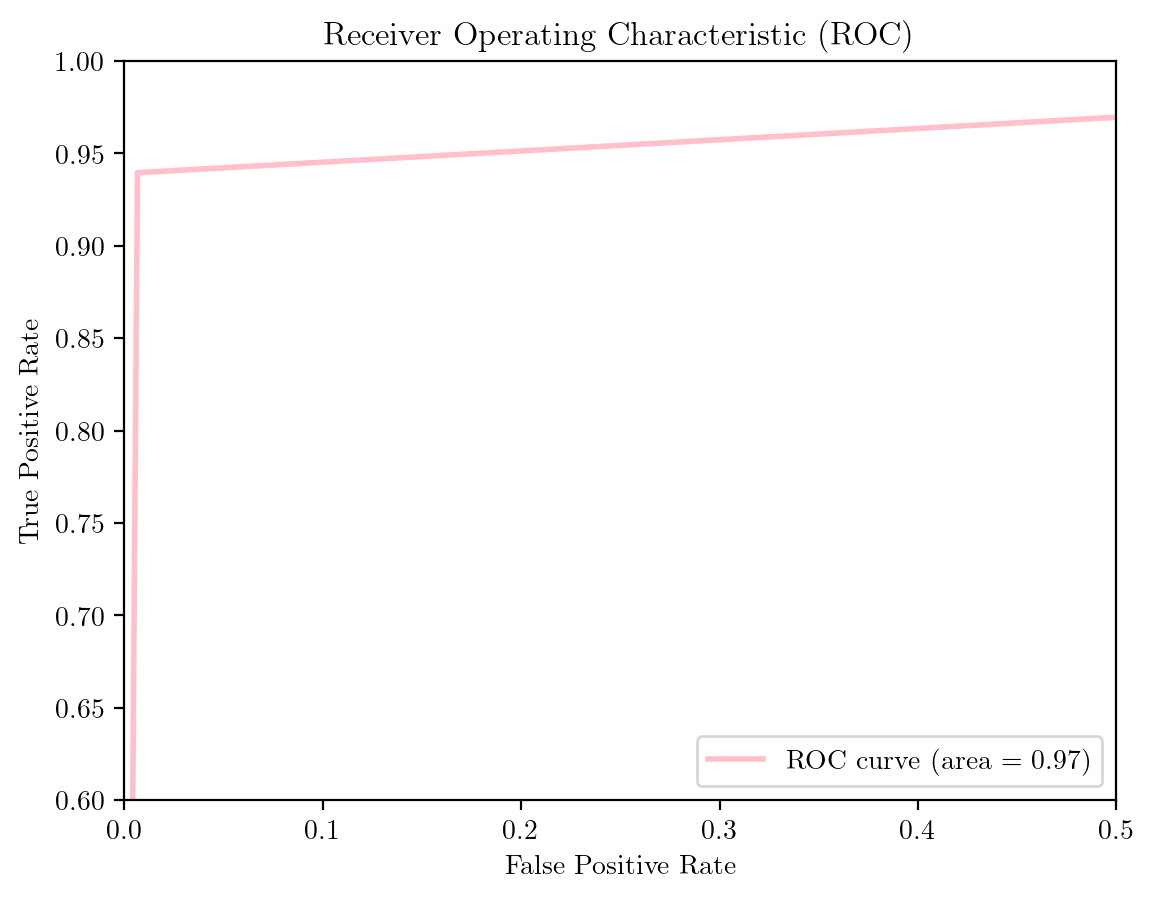

In [50]:
plot_roc_curve(model_best, X_test, lab_test)

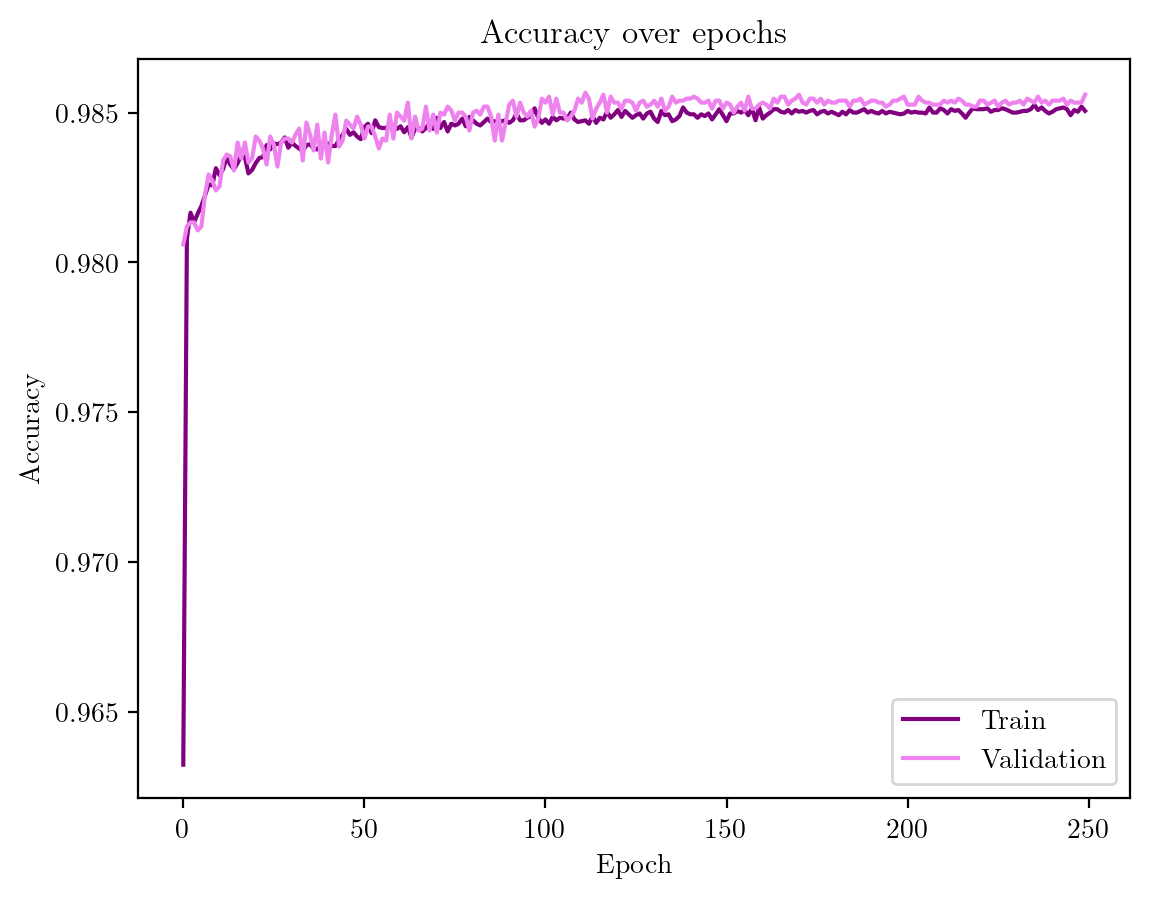

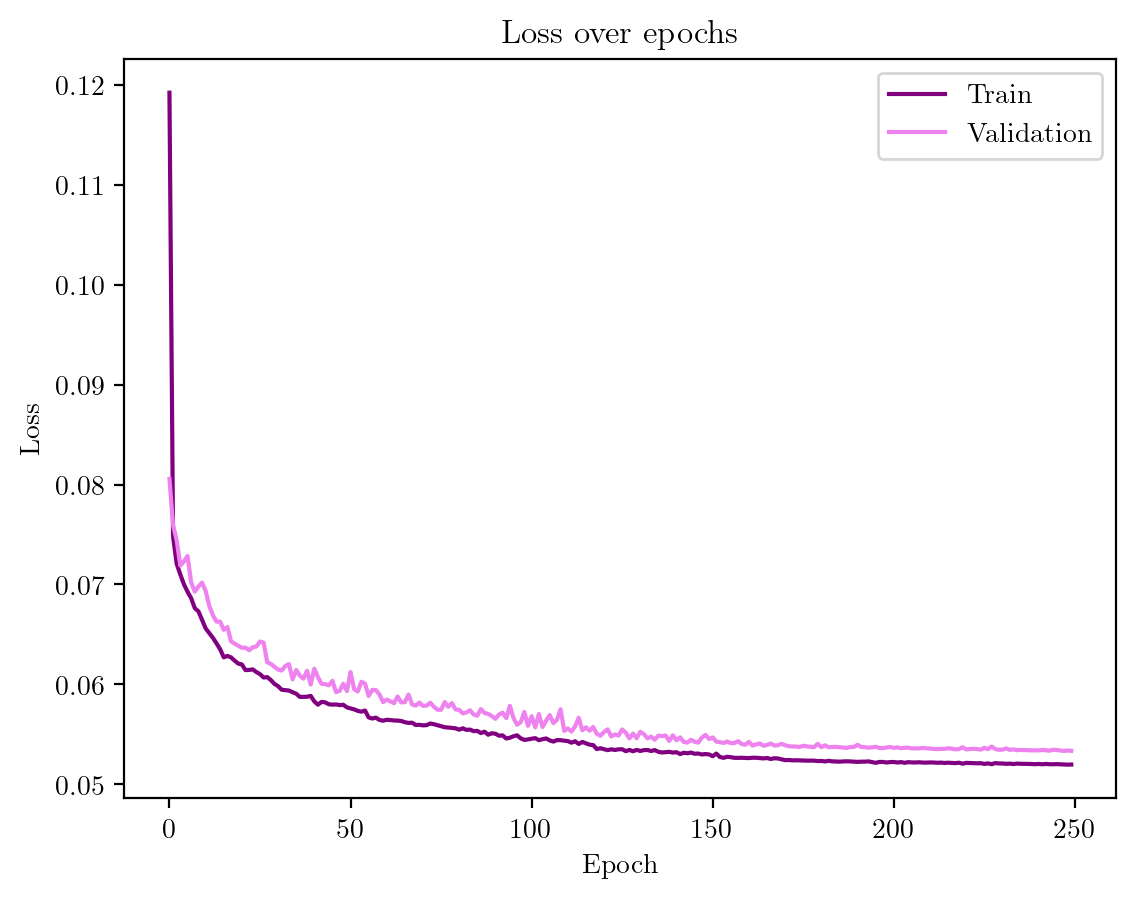

In [51]:
plots_history(history_best)